Time to combine all the knowledge gained into one dataset and train

In [118]:
import pandas as pd
import numpy as np
import ast

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import (
    FunctionTransformer,
    PowerTransformer,
    MinMaxScaler,
    OneHotEncoder,
    Binarizer,
    StandardScaler
)

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA


import mlflow
import mlflow.sklearn

from matplotlib import pyplot as plt
import seaborn as sns

# 1. Data loading

### 1.1 Raw data and NLP

In [2]:
df_train = pd.read_csv('../data/raw/actuarial-loss-estimation/train.csv', parse_dates=['DateTimeOfAccident', 'DateReported'], index_col=0)
df_nlp_descriptors_train = pd.read_csv('../data/processed/df_train_nlp_completions.csv', index_col=0)

df_embeddings_events = pd.read_csv('../data/processed/embeddings_events.csv', index_col=0)
df_embeddings_body_parts = pd.read_csv('../data/processed/embeddings_body_parts.csv', index_col=0)

In [3]:
df_test = pd.read_csv('../data/raw/actuarial-loss-estimation/test.csv', parse_dates=['DateTimeOfAccident', 'DateReported'], index_col=0)
df_nlp_descriptors_test = pd.read_csv('../data/processed/df_test_nlp_completions.csv', index_col=0)

Deriving columns

In [4]:
df_train['YearAccident'] = df_train['DateTimeOfAccident'].dt.year
df_train['DaysToReport'] = (df_train['DateReported'] - df_train['DateTimeOfAccident']).dt.days + 1 # no zero values


In [197]:
df_test['YearAccident'] = df_test['DateTimeOfAccident'].dt.year
df_test['DaysToReport'] = (df_test['DateReported'] - df_test['DateTimeOfAccident']).dt.days + 1 # no zero values


Exclusions

In [5]:
# exlude outlier 
df_train = df_train[df_train.UltimateIncurredClaimCost < 4e6]

### 1.2 Events data

In [6]:
def get_embeddings_event(nlp_descriptors: pd.Series, df_embeddings: pd.DataFrame):
    """
    nlp_descriptors: pandas Series with the claim number as index and event (str) as values
    df_embeddings: a pandas DataFrame containing all the feature values 
    """
    df = nlp_descriptors.to_frame().join(df_embeddings, on='event')[df_embeddings.columns]

    df.columns = [f'event_{col}' for col in df.columns]

    return df

In [7]:
df_events_embeddings_train = get_embeddings_event(df_nlp_descriptors_train['event'], df_embeddings_events)
df_events_embeddings_test = get_embeddings_event(df_nlp_descriptors_test['event'], df_embeddings_events)

In [8]:
# get_dummies_top_events
def get_dummies_top_events(nlp_descriptors: pd.Series): 
    """
    nlp_descriptors: pandas Series with the claim number as index and event (str) as values
    df_embeddings: a pandas DataFrame containing all the feature values 
    """
    event_values = nlp_descriptors['event'].str.strip()
    top_events = event_values.value_counts().iloc[2:50].index.values
    mask = event_values.str.strip().isin(top_events)

    return pd.get_dummies(nlp_descriptors.loc[mask, 'event'].str.strip())

### It is wrong to apply it to train and test

In [9]:
df_events_dummies_train = get_dummies_top_events(df_nlp_descriptors_train)
df_events_dummies_test = pd.get_dummies(df_nlp_descriptors_test['event'].str.strip())[df_events_dummies_train.columns.str.strip()]

Median UltimateCost per event

In [10]:
# Including the current row will result in data contamination (specially for low-frequency values)

def safe_event_median_cost(
        nlp_descriptors_train: pd.Series, 
        ultimate_cost: pd.Series,
        nlp_descriptors_test: pd.Series
    ):
    """
    Computes a safe event-based median cost feature using an out-of-fold approach 
    to prevent data contamination and target leakage.

    Parameters: 
        nlp_descriptors_train : pd.Series
            A pandas Series with claim numbers as the index and event names (str) as values.
        ultimate_cost : pd.Series
            A pandas Series containing the target variable (e.g., claim cost), with claim numbers as the index.
        nlp_descriptors_test : pd.Series
            A pandas Series with claim numbers as the index and event names (str) as values, representing the test set
    
    Returns tuple (pd.Series, pd.Series)
        - The first Series contains the out-of-fold median cost values for the training set.
        - The second Series contains the median cost values applied to the test set 
          using medians computed from the training set.
    """


    df_train = nlp_descriptors_train.rename('event').to_frame().join(ultimate_cost.rename('claim_cost'))
    df_test = nlp_descriptors_test.rename('event').to_frame()

    # fills data for training in a safe way using folds
    kf = KFold(n_splits=20, shuffle=True, random_state=42)

    for reference_idx, fill_idx in kf.split(df_train):
        fold_reference, fold_to_fill = df_train.iloc[reference_idx], df_train.iloc[fill_idx]        
        
        # Compute category median using only the training folds
        fold_medians_event = fold_reference.groupby('event')['claim_cost'].median()
        fold_median_general = fold_reference['claim_cost'].median()
        

        # Apply to validation fold
        df_train.loc[fold_to_fill.index, 'event_median_cost'] = df_train.loc[fold_to_fill.index, 'event'].map(fold_medians_event)
        df_train.loc[fold_to_fill.index, 'event_median_cost'] = df_train.loc[fold_to_fill.index, 'event_median_cost'].fillna(fold_median_general)


    # for test, it uses median from training
    df_test['event_median_cost'] = df_test['event'].map(
        df_train.groupby('event')['claim_cost'].median()
    )
    df_test['event_median_cost'] = df_test['event_median_cost'].fillna(df_train['claim_cost'].median())


    return df_train['event_median_cost'], df_test['event_median_cost']


In [11]:
s_median_cost_event_train, s_median_cost_event_test = safe_event_median_cost(
        df_nlp_descriptors_train['event'],
        df_train['UltimateIncurredClaimCost'],
        df_nlp_descriptors_test['event']
    )

### 1.3 Body parts data

In [12]:

def get_embeddings_body_parts(nlp_descriptors: pd.Series, df_embeddings: pd.DataFrame):
    """
    nlp_descriptors: pandas Series with the claim number as index and body_parts (str) as values
    df_embeddings: a pandas DataFrame containing all the feature values 
    """

    # Converts literal to lists
    def safe_eval(value):
        try:
            return ast.literal_eval(value) if isinstance(value, str) and value.startswith("[") else [value]
        except (SyntaxError, ValueError):
            return [value]

    # converts strings to list and explode them    
    df = nlp_descriptors.affected_body_part.apply(safe_eval).explode().astype(str)
    # adds the embeddings
    df = df.to_frame().join(df_embeddings, on='affected_body_part')[df_embeddings.columns]
    # mean pooling when multiple body parts are affected
    df = df.groupby(level=0).mean()
    # rename columns 
    df.columns = [f'body_{col}' for col in df.columns]

    return df

In [13]:
df_body_parts_embeddings_train = get_embeddings_body_parts(df_nlp_descriptors_train, df_embeddings_body_parts)
df_body_parts_embeddings_test = get_embeddings_body_parts(df_nlp_descriptors_test, df_embeddings_body_parts)

In [14]:
df_body_parts_embeddings_train = df_body_parts_embeddings_train.fillna(df_body_parts_embeddings_train.mean())
df_body_parts_embeddings_test = df_body_parts_embeddings_test.fillna(df_body_parts_embeddings_train.mean())

# 2. Make dataset

In [15]:
dataset_train = pd.concat([
    df_train, 
    df_events_embeddings_train, 
    df_events_dummies_train, 
    s_median_cost_event_train, 
    df_body_parts_embeddings_train
], axis=1).dropna(subset='UltimateIncurredClaimCost')

In [16]:
cols_event_embeddings = df_events_embeddings_train.columns
cols_event_dummies = df_events_dummies_train.columns
# event_median_cost is a single column (series)
cols_body_parts_embeddings = df_body_parts_embeddings_train.columns

In [17]:
# fill null for event dummies
dataset_train.loc[dataset_train[cols_event_dummies].isnull().any(axis=1), cols_event_dummies] = False

In [199]:
dataset_test = pd.concat([
    df_test, 
    df_events_embeddings_test, 
    df_events_dummies_test, 
    s_median_cost_event_test, 
    df_body_parts_embeddings_test
], axis=1)

In [200]:
# fill null for event dummies
dataset_test.loc[dataset_test[cols_event_dummies].isnull().any(axis=1), cols_event_dummies] = False

# 3. Training

In [20]:
def train_cv(model, X, y, metric = 'rmse', kfold = 5):

    if metric != 'rmse':
        raise NotImplemented

    scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')

    mse_scores = -scores
    rmse_scores = np.sqrt(mse_scores)

    return rmse_scores.mean(), rmse_scores.std()

### 3.1 Pipelines

In [110]:
log_transformer = Pipeline([
    ('log', FunctionTransformer(np.log, validate=False)),
    ('scaler', StandardScaler()) 
])

# gender to bool 
def gender_to_bool(gender_column):
    """
    - Fill missing values with 'M'
    - Replace 'U' with 'M'
    - Return a boolean-ish column: 1 for 'M', 0 otherwise
    """
    g = pd.Series(gender_column.squeeze(), dtype=str).fillna('M').replace('U', 'M')
    is_male = (g == 'M').astype(int)
    return is_male.values.reshape(-1, 1)

gender_transformer = FunctionTransformer(gender_to_bool, validate=False)

# hours worked per week -> to buckets -> to one_hot
def bucket_hours_worked(dtt_array):
    return pd.cut(
        dtt_array.squeeze(), 
        bins=[-np.inf, 37, 41, np.inf],
        labels=["<=37", "37-41", ">41"]
    ).astype(str).values.reshape(-1, 1)

hours_worked_bucketer = FunctionTransformer(bucket_hours_worked, validate=False)
hours_worked_encoder = OneHotEncoder(drop='first')
hours_worked_pipeline = Pipeline([
    ('bucketizer', hours_worked_bucketer),
    ('encoder', hours_worked_encoder)
])

# DaysToReport (DateReported - DateTimeOfAccident) -> to buckets -> to one_hot
def bucket_days_to_report(dtt_array):
    return pd.cut(
        dtt_array.squeeze(), 
        bins=[-np.inf, 80, 300, 500, np.inf],
        labels=["<=80", "80-300", "300-500", ">500"]
    ).astype(str).values.reshape(-1, 1)

days_to_report_bucketer = FunctionTransformer(bucket_days_to_report, validate=False)
days_to_report_encoder = OneHotEncoder(drop='first')
days_to_report_pipeline = Pipeline([
    ('bucketizer', days_to_report_bucketer),
    ('encoder', days_to_report_encoder)
])

# DaysWorkedPerWeek -> 1 if equals 5, 0 in any other case 
def days_worked_binarize(days_array):
    # Ensure we handle arrays or DataFrames by squeezing to 1D
    days = days_array.squeeze()
    binarized = (days == 5).astype(int)
    # Return as 2D array: (n_samples x 1)
    return binarized.values.reshape(-1, 1) if isinstance(days, pd.Series) else binarized.reshape(-1, 1)

days_worked_transformer = FunctionTransformer(days_worked_binarize, validate=False)

In [111]:
X_train = dataset_train.drop(columns=['UltimateIncurredClaimCost', 'DateTimeOfAccident', 'DateReported', 'ClaimDescription'])
y_train = dataset_train['UltimateIncurredClaimCost']

In [160]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log_inc', log_transformer, ['InitialIncurredCalimsCost', 'WeeklyWages']),
        ('minmax_scaler', MinMaxScaler(), ['Age', 'YearAccident']),
        ('gender_bool', gender_transformer, ['Gender']),
        ('hww_bool_onehot', hours_worked_pipeline, ['HoursWorkedPerWeek']),
        ('dtt_bool_onehot', days_to_report_pipeline, ['DaysToReport']),
        ('has_dependent_bool', Binarizer(threshold=0), ['DependentChildren']),
        ('worked_five_days_bool', days_worked_transformer, ['DaysWorkedPerWeek']),
        ('onehot', OneHotEncoder(drop='first'), ['MaritalStatus', 'PartTimeFullTime']),
        ('pca_event_embeddings', PCA(n_components=20), cols_event_embeddings),
        ('passthrough_event_dummies', 'passthrough', cols_event_dummies),
        ('pca_body_parts_embeddings', PCA(n_components=20), cols_body_parts_embeddings),
        ('std_scaler', StandardScaler(), ['event_median_cost'])
    ],
    remainder='drop'
)

In [114]:
regressor_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('linear_model', XGBRegressor())
])

model = TransformedTargetRegressor(
    regressor=regressor_pipeline,
    transformer=PowerTransformer(method='box-cox', standardize=False)
)

In [115]:

scores = cross_val_score(
    model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='neg_mean_squared_error'
)
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)

print(f"CV MSE:  {mse_scores.mean():.3f}  (+/- {mse_scores.std():.3f})")
print(f"CV RMSE: {rmse_scores.mean():.3f}  (+/- {rmse_scores.std():.3f})")

CV MSE:  574589389.754  (+/- 51396620.043)
CV RMSE: 23945.092  (+/- 1105.425)


Using all variables yields the best RMSE so far.

Where does the error come from?

In [26]:
y_train_pred = cross_val_predict(
    model, X_train, y_train, cv=5
)

In [27]:
import numpy as np
import pandas as pd

def error_across_ranges(y_true, y_pred, num_bins=10): 

    # Create DataFrame with errors
    error_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    error_df['residual'] = error_df['y_true'] - error_df['y_pred']
    error_df['absolute_error'] = np.abs(error_df['residual'])
    error_df['squared_error'] = error_df['residual'] ** 2 


    bins = np.linspace(y_true.min(), y_true.max(), num_bins + 1)
    bin_labels = [f"{bins[i]:,.0f} - {bins[i+1]:,.0f}" for i in range(len(bins)-1)]

    error_df['range'] = pd.cut(error_df['y_true'], bins=bins, labels=bin_labels, include_lowest=True)

    result = error_df.groupby('range', observed=True).agg({
        'residual': 'count', 
        'y_true': 'median', 
        'y_pred': 'median',
        'absolute_error': 'mean',
        'squared_error': lambda x: np.sqrt(np.mean(x)) 
    }).round(1).rename(columns={
        'residual': 'n',
        'y_true': 'median_y_true',
        'y_pred': 'median_y_prediction',
        'absolute_error': 'mae',
        'squared_error': 'rmse'
    })

    return result


In [28]:
error_summary = error_across_ranges(y_train, y_train_pred)
error_summary

,n,median_y_true,median_y_prediction,mae,rmse
range,,,,,
"122 - 86,687",52782,3184.8,3244.9,3180.7,8839.6
"86,687 - 173,252",893,114506.5,29388.5,82839.8,90764.0
"173,252 - 259,817",223,207886.7,35019.2,162672.4,169361.6
"259,817 - 346,381",50,285873.6,33068.6,251473.5,256246.6
"346,381 - 432,946",26,370786.6,43310.6,319898.3,323553.6
"432,946 - 519,511",14,457384.3,35103.3,420078.5,422086.2
"519,511 - 606,076",4,547586.2,47814.2,482880.2,488321.3
"606,076 - 692,641",1,608650.4,23794.9,584855.6,584855.6
"692,641 - 779,206",4,741750.6,36800.8,696791.6,697926.2


Model error increases as the cost of the claim deviates to the right. It is specially bad at predicting the two highest values.

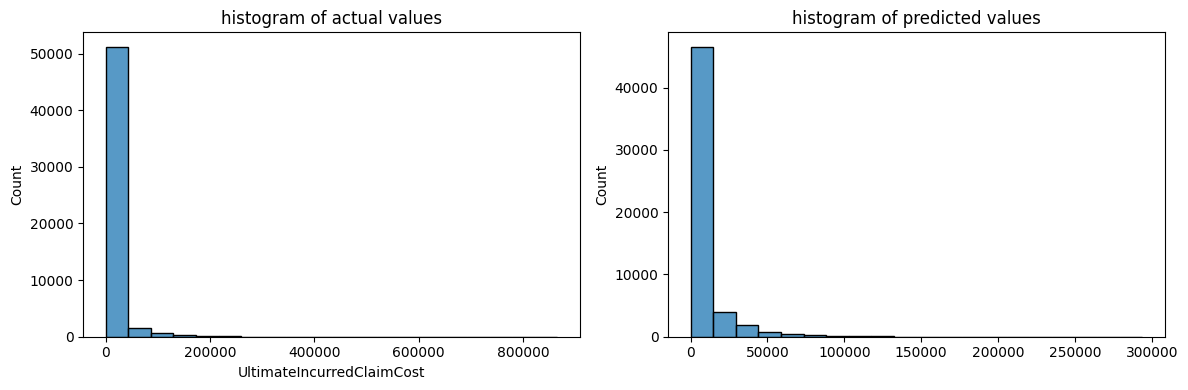

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))


sns.histplot(y_train, bins=20, ax=ax[0])
ax[0].set_title('histogram of actual values')

sns.histplot(y_train_pred, bins=20, ax=ax[1])
ax[1].set_title('histogram of predicted values')

plt.tight_layout()
plt.show()

The model struggles to predict low values

### Ready to run experiments

In [187]:
def run_experiment(
        experiment_name, 
        run_name, 
        regressor_object, 
        kfold=5, 
        save_model=True
    ):
    """
    Runs an ML experiment with cross-validation and logs metrics to MLflow,
    tracking overall and segmented performance for targets above and below 100,000.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.
    - run_name (str): Name of the MLflow run.
    - regressor_object: The regression model.
    - kfold (int): Number of folds for cross-validation.
    - save_model (bool): Whether to save the trained model in MLflow.

    Logs:
    - Overall CV MSE, RMSE, and MAE
    - MSE, RMSE, and MAE for y_true > 100,000
    - MSE, RMSE, and MAE for y_true ≤ 100,000
    """

    # Define pipeline with preprocessing and model
    regressor_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('linear_model', regressor_object)
    ])

    model = TransformedTargetRegressor(
        regressor=regressor_pipeline,
        transformer=PowerTransformer(method='box-cox', standardize=False)
    )

    # Set MLflow experiment
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name=run_name):
        # Log hyperparameters
        params = model.get_params(deep=True)
        for param_name, param_value in params.items():
            if isinstance(param_value, (str, int, float, bool, type(None))):
                mlflow.log_param(param_name, param_value)
            else:
                mlflow.log_param(param_name, str(param_value))  # Convert complex objects to string
        
        mlflow.log_param("n_features_in", X_train.shape[1])

        # Perform cross-validation with predictions
        y_pred = cross_val_predict(model, X_train, y_train, cv=kfold)

        # Compute overall errors
        overall_mse = mean_squared_error(y_train, y_pred)
        overall_rmse = np.sqrt(overall_mse)
        overall_mae = mean_absolute_error(y_train, y_pred)

        # Compute errors for high and low y_true
        high_mask = y_train > 100000

        high_mse = mean_squared_error(y_train[high_mask], y_pred[high_mask])
        high_rmse = np.sqrt(high_mse)
        high_mae = mean_absolute_error(y_train[high_mask], y_pred[high_mask])
        
        low_mse = mean_squared_error(y_train[~high_mask], y_pred[~high_mask])
        low_rmse = np.sqrt(low_mse)
        low_mae = mean_absolute_error(y_train[~high_mask], y_pred[~high_mask])
    
        print(f"RMSE Overall:  {overall_rmse:.3f} | MAE: {overall_mae:.3f}")
        print(f"RMSE for low y_true (<= 100k): {low_rmse:.3f} | MAE: {low_mae:.3f}")
        print(f"RMSE for high y_true (> 100k): {high_rmse:.3f} | MAE: {high_mae:.3f}")
        

        # Log overall metrics
        mlflow.log_metric("cv_mse", overall_mse)
        mlflow.log_metric("cv_rmse", overall_rmse)
        mlflow.log_metric("cv_mae", overall_mae)

        # Log segmented metrics
        mlflow.log_metric("cv_mse_high", high_mse)
        mlflow.log_metric("cv_rmse_high", high_rmse)
        mlflow.log_metric("cv_mae_high", high_mae)
        mlflow.log_metric("cv_mse_low", low_mse)
        mlflow.log_metric("cv_rmse_low", low_rmse)
        mlflow.log_metric("cv_mae_low", low_mae)

        # Fit final model on full dataset
        if save_model:
            model.fit(X_train, y_train)
            mlflow.sklearn.log_model(model, artifact_path="models")
    
    return overall_rmse


In [127]:
run_experiment(
    experiment_name="Actuarial Loss Prediction",
    run_name="XGBoost Run",
    regressor_object=XGBRegressor(objective="reg:squarederror"),
    kfold=5,
    save_model=False
)


Overall CV RMSE:  23970.583 | MAE: 5775.838
High Target (>100k) RMSE: 163026.045 | MAE: 133144.922
Low Target (≤100k) RMSE: 9820.900 | MAE: 3433.788


In [137]:
# baseline xgb
params = {
    "n_estimators": 100,
    "max_depth": 2,
    "learning_rate": 0.2,
    "min_child_weight": 1,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "reg_alpha": 0,
    "reg_lambda": 0,
    "gamma": 0,
    "objective": "reg:squarederror"
}

run_experiment(
    experiment_name="Actuarial Loss Prediction",
    run_name="XGBoost Run - baseline",
    regressor_object=XGBRegressor(**params),
    kfold=5,
    save_model=False
)


Overall CV RMSE:  23960.837 | MAE: 5671.620
High Target (>100k) RMSE: 164563.781 | MAE: 135032.389
Low Target (≤100k) RMSE: 9311.902 | MAE: 3292.947


In [139]:
# a deeper model 
params = {
    "n_estimators": 1000,
    "max_depth": 12,
    "learning_rate": 0.01,  # small LR
    "min_child_weight": 1,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "reg_alpha": 0,
    "reg_lambda": 0,
    "gamma": 0,
    "objective": "reg:squarederror"
}


run_experiment(
    experiment_name="Actuarial Loss Prediction",
    run_name="XGBoost Run - deeper",
    regressor_object=XGBRegressor(**params),
    kfold=5,
    save_model=False
)

Overall CV RMSE:  24043.406 | MAE: 5846.661
High Target (>100k) RMSE: 163185.518 | MAE: 133323.040
Low Target (≤100k) RMSE: 9952.604 | MAE: 3502.638


In [140]:
# heavy regularization
params = {
    "n_estimators": 1000,
    "max_depth": 4,  # Medium depth
    "learning_rate": 0.05,  # Slow learning
    "min_child_weight": 10,  # Avoid splitting on small data points
    "subsample": 0.7,  # Prevent reliance on any one sample
    "colsample_bytree": 0.7,  # Prevent reliance on any one feature
    "reg_alpha": 10,  # Strong L1 penalty
    "reg_lambda": 10,  # Strong L2 penalty
    "gamma": 10,  # Require strong gain improvement before splitting
    "objective": "reg:squarederror"
}


run_experiment(
    experiment_name="Actuarial Loss Prediction",
    run_name="XGBoost Run - regularized",
    regressor_object=XGBRegressor(**params),
    kfold=5,
    save_model=False
)


Overall CV RMSE:  24488.346 | MAE: 5629.196
High Target (>100k) RMSE: 169482.298 | MAE: 142253.732
Low Target (≤100k) RMSE: 9084.455 | MAE: 3116.958


In [141]:
# high variance
params = {
    "n_estimators": 500,
    "max_depth": 3,
    "learning_rate": 0.1,
    "min_child_weight": 1,  # No restriction on splits
    "subsample": 0.5,  # Smaller subsets
    "colsample_bytree": 0.3,  # Use only a fraction of features per tree
    "reg_alpha": 0,
    "reg_lambda": 1,  # Mild L2 regularization
    "gamma": 0,
    "objective": "reg:squarederror"
}



run_experiment(
    experiment_name="Actuarial Loss Prediction",
    run_name="XGBoost Run - high variance",
    regressor_object=XGBRegressor(**params),
    kfold=5,
    save_model=False
)

Overall CV RMSE:  23865.515 | MAE: 5696.507
High Target (>100k) RMSE: 163029.361 | MAE: 133205.491
Low Target (≤100k) RMSE: 9555.718 | MAE: 3351.885


In [142]:
# tweedie
params = {
    "n_estimators": 800,
    "max_depth": 6,
    "learning_rate": 0.05,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "gamma": 1,
    "objective": "reg:tweedie",  # Tweedie helps when target is skewed
    "tweedie_variance_power": 1.5  # 1.5 = between normal & gamma distribution
}

run_experiment(
    experiment_name="Actuarial Loss Prediction",
    run_name="XGBoost Run - tweedie",
    regressor_object=XGBRegressor(**params),
    kfold=5,
    save_model=False
)

Overall CV RMSE:  24680.108 | MAE: 5624.033
High Target (>100k) RMSE: 170946.180 | MAE: 144267.883
Low Target (≤100k) RMSE: 9108.554 | MAE: 3074.664


In [146]:
# tweedie
params = {
    "n_estimators": 800,
    "max_depth": 6,
    "learning_rate": 0.05,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "gamma": 1,
    "objective": "reg:tweedie",  # Tweedie helps when target is skewed
    "tweedie_variance_power": 1.1  # 1.5 = between normal & gamma distribution
}

run_experiment(
    experiment_name="Actuarial Loss Prediction",
    run_name="XGBoost Run - tweedie",
    regressor_object=XGBRegressor(**params),
    kfold=5,
    save_model=False
)

Overall CV RMSE:  24320.849 | MAE: 5595.617
High Target (>100k) RMSE: 168205.637 | MAE: 140396.157
Low Target (≤100k) RMSE: 9062.496 | MAE: 3116.918


### Check the number of components for PCA 

In [149]:
len(cols_event_embeddings)

768

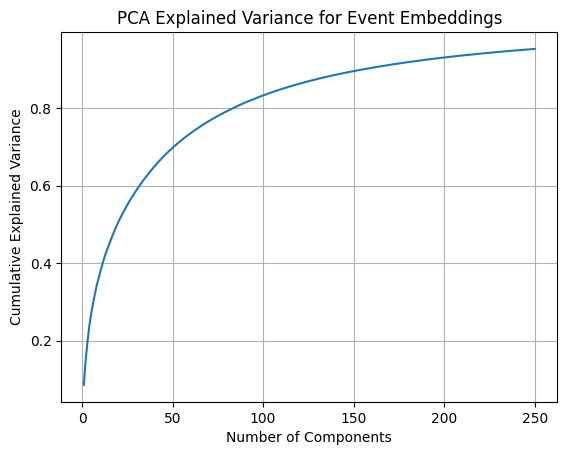

In [156]:
pca = PCA(n_components=250) 
pca.fit(X_train[cols_event_embeddings])

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance for Event Embeddings")
plt.grid()
plt.show()


PCA of 20 (current value) explains only about 50% of the variance

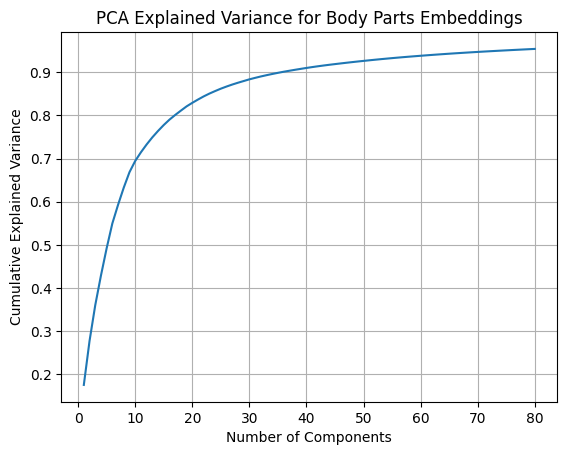

In [166]:
pca = PCA(n_components=80) 
pca.fit(X_train[cols_body_parts_embeddings])

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance for Body Parts Embeddings")
plt.grid()
plt.show()


80 components explain 95% of the variance

In [172]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log_inc', log_transformer, ['InitialIncurredCalimsCost', 'WeeklyWages']),
        ('minmax_scaler', MinMaxScaler(), ['Age', 'YearAccident']),
        ('gender_bool', gender_transformer, ['Gender']),
        ('hww_bool_onehot', hours_worked_pipeline, ['HoursWorkedPerWeek']),
        ('dtt_bool_onehot', days_to_report_pipeline, ['DaysToReport']),
        ('has_dependent_bool', Binarizer(threshold=0), ['DependentChildren']),
        ('worked_five_days_bool', days_worked_transformer, ['DaysWorkedPerWeek']),
        ('onehot', OneHotEncoder(drop='first'), ['MaritalStatus', 'PartTimeFullTime']),
        ('pca_event_embeddings', PCA(n_components=250), cols_event_embeddings),
        ('passthrough_event_dummies', 'passthrough', cols_event_dummies),
        ('pca_body_parts_embeddings', PCA(n_components=80), cols_body_parts_embeddings),
        ('std_scaler', StandardScaler(), ['event_median_cost'])
    ],
    remainder='drop'
)

In [173]:
# baseline xgb
params = {
    "n_estimators": 100,
    "max_depth": 2,
    "learning_rate": 0.2,
    "min_child_weight": 1,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "reg_alpha": 0,
    "reg_lambda": 0,
    "gamma": 0,
    "objective": "reg:squarederror"
}

run_experiment(
    experiment_name="Actuarial Loss Prediction",
    run_name="XGBoost Run - baseline - fixed PCA",
    regressor_object=XGBRegressor(**params),
    kfold=5,
    save_model=False
)


Overall CV RMSE:  23956.255 | MAE: 5661.846
High Target (>100k) RMSE: 164598.888 | MAE: 135225.710
Low Target (≤100k) RMSE: 9288.457 | MAE: 3279.438


In [182]:
# baseline xgb
params = {
    "n_estimators": 200,
    "max_depth": 2,
    "learning_rate": 0.3,
    "min_child_weight": 1,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "reg_alpha": 0,
    "reg_lambda": 0,
    "gamma": 0,
    "objective": "reg:squarederror"
}

run_experiment(
    experiment_name="Actuarial Loss Prediction",
    run_name="XGBoost Run - baseline - estimatros 200 - lr 0.3",
    regressor_object=XGBRegressor(**params),
    kfold=5,
    save_model=False
)


Overall CV RMSE:  23895.567 | MAE: 5726.734
High Target (>100k) RMSE: 162959.344 | MAE: 133110.159
Low Target (≤100k) RMSE: 9653.659 | MAE: 3384.420


Hyperparameter optimization using Optuna

In [188]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    """Objective function for Optuna to optimize XGBoost hyperparameters."""
    
    # Suggest hyperparameters to optimize
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
    }

    rmse = run_experiment(
        'Optuna XGBoost',
        'XGBoost optimization',
        XGBRegressor(**params),
        kfold=5,
        save_model=False
    )

    return rmse


In [189]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best result
print(f"Best trial: {study.best_trial.params}")


[I 2025-03-02 16:27:07,893] A new study created in memory with name: no-name-f32b307e-e28e-4d91-9dd0-aa17024ec266
2025/03/02 16:27:07 INFO mlflow.tracking.fluent: Experiment with name 'Optuna XGBoost' does not exist. Creating a new experiment.
[I 2025-03-02 16:27:37,725] Trial 0 finished with value: 23991.882604874725 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.023070886453213483, 'min_child_weight': 7, 'subsample': 0.9701610714888518, 'colsample_bytree': 0.9132495148587993, 'reg_alpha': 0.7432450632816088, 'reg_lambda': 9.356383131538275, 'gamma': 1.2677978749161611}. Best is trial 0 with value: 23991.882604874725.


RMSE Overall:  23991.883 | MAE: 5528.700
RMSE for low y_true (<= 100k): 9011.942 | MAE: 3110.780
RMSE for high y_true (> 100k): 165718.446 | MAE: 137023.900


[I 2025-03-02 16:27:48,588] Trial 1 finished with value: 24064.631423217834 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.20764924361843218, 'min_child_weight': 3, 'subsample': 0.5210376681238895, 'colsample_bytree': 0.6533259090117276, 'reg_alpha': 0.5003594670157152, 'reg_lambda': 4.387784389809704, 'gamma': 3.352224973181631}. Best is trial 0 with value: 23991.882604874725.


RMSE Overall:  24064.631 | MAE: 5630.939
RMSE for low y_true (<= 100k): 9183.525 | MAE: 3216.549
RMSE for high y_true (> 100k): 165790.350 | MAE: 136934.177


[I 2025-03-02 16:28:10,740] Trial 2 finished with value: 24058.551252352314 and parameters: {'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.088649785547953, 'min_child_weight': 10, 'subsample': 0.7559624485956563, 'colsample_bytree': 0.7301505195731823, 'reg_alpha': 0.8840305426740477, 'reg_lambda': 3.8316955639240824, 'gamma': 4.339943344218617}. Best is trial 0 with value: 23991.882604874725.


RMSE Overall:  24058.551 | MAE: 5671.198
RMSE for low y_true (<= 100k): 9208.109 | MAE: 3262.471
RMSE for high y_true (> 100k): 165667.274 | MAE: 136666.434


[I 2025-03-02 16:28:21,631] Trial 3 finished with value: 26856.79552538676 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.015427757236651029, 'min_child_weight': 8, 'subsample': 0.8404399355198962, 'colsample_bytree': 0.6355034890788194, 'reg_alpha': 0.8454665358115897, 'reg_lambda': 5.735670908993072, 'gamma': 3.020517300796693}. Best is trial 0 with value: 23991.882604874725.


RMSE Overall:  26856.796 | MAE: 6720.646
RMSE for low y_true (<= 100k): 11054.267 | MAE: 3928.663
RMSE for high y_true (> 100k): 182488.323 | MAE: 158558.722


[I 2025-03-02 16:28:49,404] Trial 4 finished with value: 24463.969441240068 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.01003457169804774, 'min_child_weight': 3, 'subsample': 0.6350335522921435, 'colsample_bytree': 0.620001386147668, 'reg_alpha': 0.8079507804353309, 'reg_lambda': 5.951415527360293, 'gamma': 2.823780751469969}. Best is trial 0 with value: 23991.882604874725.


RMSE Overall:  24463.969 | MAE: 5520.626
RMSE for low y_true (<= 100k): 9101.482 | MAE: 3013.530
RMSE for high y_true (> 100k): 169237.465 | MAE: 141865.483


[I 2025-03-02 16:29:07,438] Trial 5 finished with value: 23976.13939291646 and parameters: {'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.28734694499802754, 'min_child_weight': 3, 'subsample': 0.8287304179695976, 'colsample_bytree': 0.7468909735886304, 'reg_alpha': 0.017131410039369355, 'reg_lambda': 0.0544794926416059, 'gamma': 1.2325620910102553}. Best is trial 5 with value: 23976.13939291646.


RMSE Overall:  23976.139 | MAE: 5695.940
RMSE for low y_true (<= 100k): 9501.597 | MAE: 3329.185
RMSE for high y_true (> 100k): 164096.858 | MAE: 134408.566


[I 2025-03-02 16:29:32,793] Trial 6 finished with value: 24155.663745301994 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.04311028433673649, 'min_child_weight': 6, 'subsample': 0.6069115540474831, 'colsample_bytree': 0.7962462948081418, 'reg_alpha': 0.23600600650410752, 'reg_lambda': 4.493140861613119, 'gamma': 4.353125579977435}. Best is trial 5 with value: 23976.13939291646.


RMSE Overall:  24155.664 | MAE: 5539.821
RMSE for low y_true (<= 100k): 8981.327 | MAE: 3085.310
RMSE for high y_true (> 100k): 167120.606 | MAE: 139024.919


[I 2025-03-02 16:29:52,976] Trial 7 finished with value: 24048.688432329018 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.21117657634626966, 'min_child_weight': 10, 'subsample': 0.8478998100860502, 'colsample_bytree': 0.9886168877649611, 'reg_alpha': 0.42200403102807515, 'reg_lambda': 5.3379528045020574, 'gamma': 0.13807103991119007}. Best is trial 5 with value: 23976.13939291646.


RMSE Overall:  24048.688 | MAE: 5827.464
RMSE for low y_true (<= 100k): 10070.314 | MAE: 3481.418
RMSE for high y_true (> 100k): 162835.520 | MAE: 133413.894


[I 2025-03-02 16:30:26,982] Trial 8 finished with value: 23935.61978630157 and parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.0179757515959304, 'min_child_weight': 10, 'subsample': 0.6240002875073307, 'colsample_bytree': 0.8716098361236918, 'reg_alpha': 0.2820486682695248, 'reg_lambda': 9.670752483722708, 'gamma': 0.6430146322592312}. Best is trial 8 with value: 23935.61978630157.


RMSE Overall:  23935.620 | MAE: 5593.857
RMSE for low y_true (<= 100k): 9186.743 | MAE: 3205.980
RMSE for high y_true (> 100k): 164743.004 | MAE: 135455.160


[I 2025-03-02 16:30:39,077] Trial 9 finished with value: 24059.8209996627 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.29403502108225105, 'min_child_weight': 5, 'subsample': 0.7922331732524719, 'colsample_bytree': 0.7177050329173408, 'reg_alpha': 0.41840680109645734, 'reg_lambda': 2.792316852210707, 'gamma': 3.310722681428588}. Best is trial 8 with value: 23935.61978630157.


RMSE Overall:  24059.821 | MAE: 5614.597
RMSE for low y_true (<= 100k): 9132.637 | MAE: 3193.720
RMSE for high y_true (> 100k): 165904.515 | MAE: 137270.610


[I 2025-03-02 16:31:00,110] Trial 10 finished with value: 23932.80356288146 and parameters: {'n_estimators': 700, 'max_depth': 2, 'learning_rate': 0.039666400304883484, 'min_child_weight': 1, 'subsample': 0.6552253050927741, 'colsample_bytree': 0.5112139890261134, 'reg_alpha': 0.04778751692245137, 'reg_lambda': 9.814699177312562, 'gamma': 0.19879090864433957}. Best is trial 10 with value: 23932.80356288146.


RMSE Overall:  23932.804 | MAE: 5732.387
RMSE for low y_true (<= 100k): 9451.121 | MAE: 3372.549
RMSE for high y_true (> 100k): 163904.908 | MAE: 134068.889


[I 2025-03-02 16:31:21,678] Trial 11 finished with value: 23932.7779603528 and parameters: {'n_estimators': 700, 'max_depth': 2, 'learning_rate': 0.038078447769056036, 'min_child_weight': 1, 'subsample': 0.647203170436217, 'colsample_bytree': 0.5410115704042113, 'reg_alpha': 0.0685984727020255, 'reg_lambda': 9.747864381235225, 'gamma': 0.14736611887797818}. Best is trial 11 with value: 23932.7779603528.


RMSE Overall:  23932.778 | MAE: 5729.217
RMSE for low y_true (<= 100k): 9436.098 | MAE: 3367.716
RMSE for high y_true (> 100k): 163951.768 | MAE: 134156.129


[I 2025-03-02 16:31:42,398] Trial 12 finished with value: 23941.374521119746 and parameters: {'n_estimators': 700, 'max_depth': 2, 'learning_rate': 0.04742681211992057, 'min_child_weight': 1, 'subsample': 0.6855182678899858, 'colsample_bytree': 0.5066908154449362, 'reg_alpha': 0.0027175814038489787, 'reg_lambda': 8.071750548828561, 'gamma': 1.7263882319856425}. Best is trial 11 with value: 23932.7779603528.


RMSE Overall:  23941.375 | MAE: 5740.078
RMSE for low y_true (<= 100k): 9457.012 | MAE: 3379.825
RMSE for high y_true (> 100k): 163955.748 | MAE: 134099.112


[I 2025-03-02 16:32:03,244] Trial 13 finished with value: 23898.679790684324 and parameters: {'n_estimators': 700, 'max_depth': 2, 'learning_rate': 0.08432125938618049, 'min_child_weight': 1, 'subsample': 0.5124767017678578, 'colsample_bytree': 0.5104553782806389, 'reg_alpha': 0.2184901700782223, 'reg_lambda': 7.773073346530749, 'gamma': 0.08136046137024179}. Best is trial 13 with value: 23898.679790684324.


RMSE Overall:  23898.680 | MAE: 5741.918
RMSE for low y_true (<= 100k): 9618.415 | MAE: 3402.587
RMSE for high y_true (> 100k): 163097.905 | MAE: 132963.126


[I 2025-03-02 16:32:24,519] Trial 14 finished with value: 24030.620844660207 and parameters: {'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.09238606506574698, 'min_child_weight': 1, 'subsample': 0.5123065223016758, 'colsample_bytree': 0.5611900518132255, 'reg_alpha': 0.18307343071045865, 'reg_lambda': 7.609346052261705, 'gamma': 2.152098703686739}. Best is trial 13 with value: 23898.679790684324.


RMSE Overall:  24030.621 | MAE: 5613.909
RMSE for low y_true (<= 100k): 9226.449 | MAE: 3211.348
RMSE for high y_true (> 100k): 165387.033 | MAE: 136273.805


[I 2025-03-02 16:32:46,939] Trial 15 finished with value: 23883.718182020944 and parameters: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.08496531765732618, 'min_child_weight': 4, 'subsample': 0.5654007331997579, 'colsample_bytree': 0.5943596332426031, 'reg_alpha': 0.6202377146669086, 'reg_lambda': 7.608858141563199, 'gamma': 0.8488428031047912}. Best is trial 15 with value: 23883.718182020944.


RMSE Overall:  23883.718 | MAE: 5671.451
RMSE for low y_true (<= 100k): 9460.177 | MAE: 3315.802
RMSE for high y_true (> 100k): 163479.403 | MAE: 133780.123


[I 2025-03-02 16:33:06,881] Trial 16 finished with value: 23895.72236762192 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.09502326095660843, 'min_child_weight': 4, 'subsample': 0.5629108627625132, 'colsample_bytree': 0.5907003760471393, 'reg_alpha': 0.6400439893473475, 'reg_lambda': 7.260012362700728, 'gamma': 0.8645550829785184}. Best is trial 15 with value: 23883.718182020944.


RMSE Overall:  23895.722 | MAE: 5669.989
RMSE for low y_true (<= 100k): 9459.870 | MAE: 3315.417
RMSE for high y_true (> 100k): 163577.495 | MAE: 133720.046


[I 2025-03-02 16:33:25,202] Trial 17 finished with value: 23896.469308065585 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.12687730858594923, 'min_child_weight': 4, 'subsample': 0.5797155243665343, 'colsample_bytree': 0.6716673732633263, 'reg_alpha': 0.6513739788011326, 'reg_lambda': 6.733550632120137, 'gamma': 0.9676423065701774}. Best is trial 15 with value: 23883.718182020944.


RMSE Overall:  23896.469 | MAE: 5663.550
RMSE for low y_true (<= 100k): 9468.542 | MAE: 3308.270
RMSE for high y_true (> 100k): 163556.247 | MAE: 133752.160


[I 2025-03-02 16:33:41,231] Trial 18 finished with value: 23965.190676230915 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.13805213687832799, 'min_child_weight': 5, 'subsample': 0.56703734470251, 'colsample_bytree': 0.5734049547407263, 'reg_alpha': 0.6040727344582782, 'reg_lambda': 6.754734883462472, 'gamma': 1.8890355088311315}. Best is trial 15 with value: 23883.718182020944.


RMSE Overall:  23965.191 | MAE: 5624.628
RMSE for low y_true (<= 100k): 9247.832 | MAE: 3238.124
RMSE for high y_true (> 100k): 164795.212 | MAE: 135411.264


[I 2025-03-02 16:33:59,118] Trial 19 finished with value: 24153.840574988357 and parameters: {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.06909763331587086, 'min_child_weight': 4, 'subsample': 0.7191498427701399, 'colsample_bytree': 0.5978974376226147, 'reg_alpha': 0.9648240713713373, 'reg_lambda': 8.624472334606201, 'gamma': 4.981610483171717}. Best is trial 15 with value: 23883.718182020944.


RMSE Overall:  24153.841 | MAE: 5614.387
RMSE for low y_true (<= 100k): 9139.441 | MAE: 3175.339
RMSE for high y_true (> 100k): 166639.139 | MAE: 138258.561


[I 2025-03-02 16:34:21,150] Trial 20 finished with value: 23883.6512121492 and parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.1494021951321665, 'min_child_weight': 7, 'subsample': 0.9693317649910538, 'colsample_bytree': 0.8189984000637519, 'reg_alpha': 0.6482962464313586, 'reg_lambda': 2.2561218553835323, 'gamma': 0.7821727380297361}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23883.651 | MAE: 5615.031
RMSE for low y_true (<= 100k): 9303.257 | MAE: 3246.929
RMSE for high y_true (> 100k): 163967.872 | MAE: 134400.952


[I 2025-03-02 16:34:43,790] Trial 21 finished with value: 23894.69967167379 and parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.13822304998158916, 'min_child_weight': 8, 'subsample': 0.927091405999726, 'colsample_bytree': 0.8148455916608067, 'reg_alpha': 0.6191808039970329, 'reg_lambda': 1.3419937407443454, 'gamma': 0.7762207655890109}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23894.700 | MAE: 5620.652
RMSE for low y_true (<= 100k): 9348.457 | MAE: 3254.596
RMSE for high y_true (> 100k): 163917.204 | MAE: 134295.227


[I 2025-03-02 16:35:04,712] Trial 22 finished with value: 23945.625826087726 and parameters: {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.13943780300695677, 'min_child_weight': 8, 'subsample': 0.992767864958563, 'colsample_bytree': 0.8036336834428058, 'reg_alpha': 0.5199578776951658, 'reg_lambda': 1.2017285108891196, 'gamma': 1.5130125002268904}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23945.626 | MAE: 5621.710
RMSE for low y_true (<= 100k): 9228.434 | MAE: 3234.554
RMSE for high y_true (> 100k): 164696.807 | MAE: 135443.801


[I 2025-03-02 16:35:28,565] Trial 23 finished with value: 23906.207174024825 and parameters: {'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.1699070114468097, 'min_child_weight': 8, 'subsample': 0.9302978920264583, 'colsample_bytree': 0.8348809585926625, 'reg_alpha': 0.7098231362481953, 'reg_lambda': 2.3307588648971276, 'gamma': 0.5742288679523483}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23906.207 | MAE: 5639.012
RMSE for low y_true (<= 100k): 9322.691 | MAE: 3268.247
RMSE for high y_true (> 100k): 164089.847 | MAE: 134569.717


[I 2025-03-02 16:35:52,137] Trial 24 finished with value: 23998.51303964939 and parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.061635253418805123, 'min_child_weight': 7, 'subsample': 0.9065060248580099, 'colsample_bytree': 0.9001476128831025, 'reg_alpha': 0.5674551636915076, 'reg_lambda': 1.5295357461766528, 'gamma': 2.3132148167155107}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23998.513 | MAE: 5567.298
RMSE for low y_true (<= 100k): 9060.953 | MAE: 3153.732
RMSE for high y_true (> 100k): 165626.250 | MAE: 136825.667


[I 2025-03-02 16:36:15,970] Trial 25 finished with value: 23887.11491395782 and parameters: {'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.11729388808653099, 'min_child_weight': 9, 'subsample': 0.9020431425335915, 'colsample_bytree': 0.7881666325000708, 'reg_alpha': 0.4062129724870021, 'reg_lambda': 0.06749317154377721, 'gamma': 0.6459339172229304}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23887.115 | MAE: 5625.942
RMSE for low y_true (<= 100k): 9319.990 | MAE: 3252.912
RMSE for high y_true (> 100k): 163944.134 | MAE: 134679.856


[I 2025-03-02 16:36:39,376] Trial 26 finished with value: 24049.943253272835 and parameters: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.11072021240849568, 'min_child_weight': 9, 'subsample': 0.8628124917063801, 'colsample_bytree': 0.6975313917946361, 'reg_alpha': 0.4186889743409564, 'reg_lambda': 0.6836439613565399, 'gamma': 1.2690772389294764}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  24049.943 | MAE: 5552.143
RMSE for low y_true (<= 100k): 9111.546 | MAE: 3129.395
RMSE for high y_true (> 100k): 165888.261 | MAE: 137309.858


[I 2025-03-02 16:37:02,501] Trial 27 finished with value: 23930.75276002589 and parameters: {'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.1904283493225697, 'min_child_weight': 6, 'subsample': 0.8915798900493352, 'colsample_bytree': 0.7643745442724857, 'reg_alpha': 0.33015172424124023, 'reg_lambda': 2.9968720414218386, 'gamma': 0.4688087892221433}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23930.753 | MAE: 5698.425
RMSE for low y_true (<= 100k): 9566.258 | MAE: 3338.567
RMSE for high y_true (> 100k): 163524.629 | MAE: 134036.006


[I 2025-03-02 16:37:23,917] Trial 28 finished with value: 24049.047650041488 and parameters: {'n_estimators': 600, 'max_depth': 8, 'learning_rate': 0.06755572744761541, 'min_child_weight': 9, 'subsample': 0.9583055726338837, 'colsample_bytree': 0.8646514093505185, 'reg_alpha': 0.3706541644609876, 'reg_lambda': 2.1869676072347355, 'gamma': 1.924671440375181}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  24049.048 | MAE: 5526.704
RMSE for low y_true (<= 100k): 8994.783 | MAE: 3095.727
RMSE for high y_true (> 100k): 166227.267 | MAE: 137731.983


[I 2025-03-02 16:37:47,793] Trial 29 finished with value: 23938.53475549113 and parameters: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.05380011161461099, 'min_child_weight': 7, 'subsample': 0.997221424972791, 'colsample_bytree': 0.7763838756360968, 'reg_alpha': 0.7320589959675798, 'reg_lambda': 0.5027054233569495, 'gamma': 1.1586154096538235}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23938.535 | MAE: 5563.634
RMSE for low y_true (<= 100k): 9102.468 | MAE: 3166.407
RMSE for high y_true (> 100k): 165020.631 | MAE: 135933.432


[I 2025-03-02 16:38:07,217] Trial 30 finished with value: 23934.94664915512 and parameters: {'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.11436185298989433, 'min_child_weight': 9, 'subsample': 0.7921935000254251, 'colsample_bytree': 0.9598340856787873, 'reg_alpha': 0.7843487433903538, 'reg_lambda': 8.756304162915749, 'gamma': 1.4270527266798148}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23934.947 | MAE: 5574.420
RMSE for low y_true (<= 100k): 9097.131 | MAE: 3176.519
RMSE for high y_true (> 100k): 165007.810 | MAE: 135980.845


[I 2025-03-02 16:38:29,283] Trial 31 finished with value: 23929.731553934264 and parameters: {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.15904723678040153, 'min_child_weight': 7, 'subsample': 0.9554608219736576, 'colsample_bytree': 0.812241579325336, 'reg_alpha': 0.5713578781385827, 'reg_lambda': 1.6555298148170783, 'gamma': 0.9337270063065977}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23929.732 | MAE: 5644.697
RMSE for low y_true (<= 100k): 9383.891 | MAE: 3276.168
RMSE for high y_true (> 100k): 164090.039 | MAE: 134453.809


[I 2025-03-02 16:38:57,392] Trial 32 finished with value: 23891.059348173087 and parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.07649983618561523, 'min_child_weight': 8, 'subsample': 0.9127270940860062, 'colsample_bytree': 0.8500011457829199, 'reg_alpha': 0.6856744950768308, 'reg_lambda': 3.5295688132641354, 'gamma': 0.5380019081803951}. Best is trial 20 with value: 23883.6512121492.


RMSE Overall:  23891.059 | MAE: 5612.208
RMSE for low y_true (<= 100k): 9351.661 | MAE: 3245.964
RMSE for high y_true (> 100k): 163877.871 | MAE: 134297.036


[I 2025-03-02 16:39:28,367] Trial 33 finished with value: 23845.520350908555 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.07733651173351022, 'min_child_weight': 6, 'subsample': 0.8826700954083797, 'colsample_bytree': 0.8526671678597144, 'reg_alpha': 0.6828611152700053, 'reg_lambda': 3.4708419387090728, 'gamma': 0.49023499265580806}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23845.520 | MAE: 5609.037
RMSE for low y_true (<= 100k): 9323.978 | MAE: 3248.347
RMSE for high y_true (> 100k): 163596.076 | MAE: 133991.853


[I 2025-03-02 16:40:15,881] Trial 34 finished with value: 23854.14132865613 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.030083843165047502, 'min_child_weight': 6, 'subsample': 0.8804735138707654, 'colsample_bytree': 0.9089650259772861, 'reg_alpha': 0.49720975763013553, 'reg_lambda': 3.9182522568551748, 'gamma': 0.4981151231994361}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23854.141 | MAE: 5573.207
RMSE for low y_true (<= 100k): 9177.514 | MAE: 3192.307
RMSE for high y_true (> 100k): 164115.263 | MAE: 135055.076


[I 2025-03-02 16:41:11,607] Trial 35 finished with value: 23877.920974985198 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.026787706807264482, 'min_child_weight': 6, 'subsample': 0.8036264664128667, 'colsample_bytree': 0.9228535051209923, 'reg_alpha': 0.5291639914753239, 'reg_lambda': 4.183580429086017, 'gamma': 0.44663894601405857}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23877.921 | MAE: 5585.119
RMSE for low y_true (<= 100k): 9221.581 | MAE: 3208.016
RMSE for high y_true (> 100k): 164172.437 | MAE: 134860.490


[I 2025-03-02 16:42:55,106] Trial 36 finished with value: 23935.73076040512 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.031245542965671575, 'min_child_weight': 6, 'subsample': 0.8074110607405098, 'colsample_bytree': 0.918313016503599, 'reg_alpha': 0.5131382795422473, 'reg_lambda': 4.278685293065181, 'gamma': 0.0073420939843279465}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23935.731 | MAE: 5689.039
RMSE for low y_true (<= 100k): 9589.212 | MAE: 3330.518
RMSE for high y_true (> 100k): 163491.863 | MAE: 133953.908


[I 2025-03-02 16:44:10,186] Trial 37 finished with value: 23895.12876505176 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.024356093906531418, 'min_child_weight': 5, 'subsample': 0.7559464912266081, 'colsample_bytree': 0.936996114995398, 'reg_alpha': 0.9047987858064032, 'reg_lambda': 4.725057463434187, 'gamma': 0.34587739319880756}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23895.129 | MAE: 5595.773
RMSE for low y_true (<= 100k): 9222.171 | MAE: 3214.656
RMSE for high y_true (> 100k): 164309.239 | MAE: 135089.441


[I 2025-03-02 16:44:43,357] Trial 38 finished with value: 24080.80608441168 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.028317432290160108, 'min_child_weight': 6, 'subsample': 0.8753047381471858, 'colsample_bytree': 0.8914296387311238, 'reg_alpha': 0.48515880854965165, 'reg_lambda': 3.6830936218062376, 'gamma': 2.5628472415564074}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  24080.806 | MAE: 5521.604
RMSE for low y_true (<= 100k): 8980.359 | MAE: 3082.474
RMSE for high y_true (> 100k): 166524.052 | MAE: 138170.241


[I 2025-03-02 16:45:31,087] Trial 39 finished with value: 23945.999685645307 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.018204060657117823, 'min_child_weight': 6, 'subsample': 0.8441981934347157, 'colsample_bytree': 0.9961621579287027, 'reg_alpha': 0.7677069336324112, 'reg_lambda': 5.312325859241588, 'gamma': 1.1033205884363941}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23946.000 | MAE: 5545.256
RMSE for low y_true (<= 100k): 9043.867 | MAE: 3140.123
RMSE for high y_true (> 100k): 165255.672 | MAE: 136345.023


[I 2025-03-02 16:45:43,246] Trial 40 finished with value: 24596.797739602862 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.032798002825236594, 'min_child_weight': 7, 'subsample': 0.8181622842097656, 'colsample_bytree': 0.9425354478766311, 'reg_alpha': 0.4830339867958826, 'reg_lambda': 2.9023584468399943, 'gamma': 3.888241280617766}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  24596.798 | MAE: 5500.021
RMSE for low y_true (<= 100k): 9054.383 | MAE: 2961.057
RMSE for high y_true (> 100k): 170436.910 | MAE: 143578.008


[I 2025-03-02 16:47:07,301] Trial 41 finished with value: 23865.60727530269 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.014402254174425507, 'min_child_weight': 5, 'subsample': 0.7772546625380236, 'colsample_bytree': 0.842387336256802, 'reg_alpha': 0.5547141003650069, 'reg_lambda': 4.116400591523429, 'gamma': 0.378241920076269}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23865.607 | MAE: 5583.032
RMSE for low y_true (<= 100k): 9230.182 | MAE: 3206.803
RMSE for high y_true (> 100k): 164046.940 | MAE: 134810.872


[I 2025-03-02 16:48:31,048] Trial 42 finished with value: 23871.937088283627 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.014328380394555461, 'min_child_weight': 5, 'subsample': 0.7859900296829502, 'colsample_bytree': 0.8800062536788846, 'reg_alpha': 0.5462418179935722, 'reg_lambda': 4.1690376790225825, 'gamma': 0.3776025211117525}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23871.937 | MAE: 5583.325
RMSE for low y_true (<= 100k): 9222.886 | MAE: 3206.321
RMSE for high y_true (> 100k): 164120.247 | MAE: 134853.370


[I 2025-03-02 16:49:56,693] Trial 43 finished with value: 23890.680531294372 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.012986956937527891, 'min_child_weight': 5, 'subsample': 0.7231823040445026, 'colsample_bytree': 0.87623662745312, 'reg_alpha': 0.5474522336885942, 'reg_lambda': 4.122392858470491, 'gamma': 0.2788765521162879}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23890.681 | MAE: 5582.965
RMSE for low y_true (<= 100k): 9226.227 | MAE: 3205.044
RMSE for high y_true (> 100k): 164261.027 | MAE: 134902.838


[I 2025-03-02 16:51:54,473] Trial 44 finished with value: 23880.78821472021 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.011592815808944883, 'min_child_weight': 5, 'subsample': 0.7340703883225785, 'colsample_bytree': 0.960594509724294, 'reg_alpha': 0.4644455006889099, 'reg_lambda': 4.921917127702167, 'gamma': 0.32939187529948943}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23880.788 | MAE: 5578.831
RMSE for low y_true (<= 100k): 9186.586 | MAE: 3196.540
RMSE for high y_true (> 100k): 164302.181 | MAE: 135136.355


[I 2025-03-02 16:52:53,574] Trial 45 finished with value: 23874.87268567543 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01930152725168089, 'min_child_weight': 3, 'subsample': 0.7833700513533854, 'colsample_bytree': 0.9244977108135918, 'reg_alpha': 0.6881998541864849, 'reg_lambda': 5.924095365825223, 'gamma': 0.4861798642151316}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23874.873 | MAE: 5585.208
RMSE for low y_true (<= 100k): 9231.400 | MAE: 3210.228
RMSE for high y_true (> 100k): 164117.865 | MAE: 134745.156


[I 2025-03-02 16:53:13,180] Trial 46 finished with value: 24295.59372876332 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01892454893969501, 'min_child_weight': 3, 'subsample': 0.7690126267645642, 'colsample_bytree': 0.892038504358537, 'reg_alpha': 0.8349040782501462, 'reg_lambda': 6.202318676654988, 'gamma': 1.387236164146072}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  24295.594 | MAE: 5474.539
RMSE for low y_true (<= 100k): 8979.359 | MAE: 2988.310
RMSE for high y_true (> 100k): 168245.977 | MAE: 140684.618


[I 2025-03-02 16:53:54,966] Trial 47 finished with value: 24000.189489591998 and parameters: {'n_estimators': 900, 'max_depth': 7, 'learning_rate': 0.015424110038041818, 'min_child_weight': 2, 'subsample': 0.6931320471473279, 'colsample_bytree': 0.8412144546251801, 'reg_alpha': 0.6814011971950474, 'reg_lambda': 5.698256820700219, 'gamma': 1.6271357019813883}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  24000.189 | MAE: 5526.882
RMSE for low y_true (<= 100k): 9012.790 | MAE: 3107.817
RMSE for high y_true (> 100k): 165782.543 | MAE: 137084.316


[I 2025-03-02 16:56:41,639] Trial 48 finished with value: 23931.853943772745 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.022114675823217987, 'min_child_weight': 2, 'subsample': 0.7761069336960829, 'colsample_bytree': 0.9755519015637472, 'reg_alpha': 0.5804647552598621, 'reg_lambda': 3.4690653819215647, 'gamma': 0.08010568461258916}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23931.854 | MAE: 5658.542
RMSE for low y_true (<= 100k): 9444.522 | MAE: 3289.854
RMSE for high y_true (> 100k): 163917.915 | MAE: 134476.302


[I 2025-03-02 16:57:37,094] Trial 49 finished with value: 23951.37536752787 and parameters: {'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.01015490683421569, 'min_child_weight': 2, 'subsample': 0.8549088383955566, 'colsample_bytree': 0.861102543957245, 'reg_alpha': 0.7287145626228209, 'reg_lambda': 5.171592161395668, 'gamma': 1.1062462798794543}. Best is trial 33 with value: 23845.520350908555.


RMSE Overall:  23951.375 | MAE: 5542.659
RMSE for low y_true (<= 100k): 9050.979 | MAE: 3137.073
RMSE for high y_true (> 100k): 165277.640 | MAE: 136367.064
Best trial: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.07733651173351022, 'min_child_weight': 6, 'subsample': 0.8826700954083797, 'colsample_bytree': 0.8526671678597144, 'reg_alpha': 0.6828611152700053, 'reg_lambda': 3.4708419387090728, 'gamma': 0.49023499265580806}


### Train best model on all the training dataset

In [193]:
best_params = {
    'n_estimators': 1000, 
    'max_depth': 5,
    'learning_rate': 0.07733651173351022, 
    'min_child_weight': 6, 
    'subsample': 0.8826700954083797, 
    'colsample_bytree': 0.8526671678597144, 
    'reg_alpha': 0.6828611152700053, 
    'reg_lambda': 3.4708419387090728, 
    'gamma': 0.49023499265580806
}


regressor_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('linear_model', XGBRegressor(**best_params))
])

model = TransformedTargetRegressor(
    regressor=regressor_pipeline,
    transformer=PowerTransformer(method='box-cox', standardize=False)
)

In [194]:
model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('log_inc',
                                                                                       Pipeline(steps=[('log',
                                                                                                        FunctionTransformer(func=<ufunc 'log'>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['InitialIncurredCalimsCost',
                                                                                        'WeeklyWages']),
                                                                                      ('minmax_scaler',
                                                                                       MinMaxScaler(),
                                                                                       ['Age',
                                                                                        'YearAccident']),
                                                                                      ('gender_bool',
                                                                                       FunctionTransformer(func=<fun...
                                                                   learning_rate=0.07733651173351022,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=5,
                                                                   max_leaves=None,
                                                                   min_child_weight=6,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=1000,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=None, ...))]),
                           transformer=PowerTransformer(method='box-cox',
                                                        standardize=False))

In [204]:
y_test_pred = model.predict(dataset_test)
y_test_pred

array([ 5891.342  ,  2779.2168 , 19953.72   , ...,  6008.0527 ,
        7291.6914 ,   477.14896], shape=(36000,), dtype=float32)

In [211]:
submission_df = pd.DataFrame(zip(dataset_test.index, y_test_pred), columns=['ClaimNumber', 'UltimateIncurredClaimCost'])

print(submission_df.shape)
submission_df.head()

(36000, 2)


,ClaimNumber,UltimateIncurredClaimCost
0,WC8145235,5891.341797
1,WC2005111,2779.216797
2,WC6899143,19953.720703
3,WC5502023,314.134155
4,WC4785156,2690.900635


In [212]:
submission_df.to_csv('../data/output/submission_xgb.csv', index=False)

In [ ]:
# stores the processed datasets to continue training in other notebooks
dataset_train.to_csv('../data/processed/dataset_train.csv', index=True)
dataset_test.to_csv('../data/processed/dataset_test.csv', index=True)